# Installations

In [1]:
import sys
!{sys.executable} -m pip install spacy

In [2]:
!{sys.executable} -m pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl

^C
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? e

In [3]:
import sys
!{sys.executable} -m pip install sentencepiece nltk

In [4]:
import sys
!{sys.executable} -m pip install scikit-learn

In [5]:
import sys
!{sys.executable} -m pip install gensim

^C


In [6]:
import sys
!{sys.executable} -m pip install sentence-transformers

# Commit to GitHub

In [7]:
!pwd                # shows your current folder
!git status         # check uncommitted changes
!git add .
!git commit -m "comparing tokenization schemes,"
!git push origin main

'pwd' is not recognized as an internal or external command,
operable program or batch file.


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


[main fef4748] comparing tokenization schemes,
 1 file changed, 12 insertions(+), 3 deletions(-)


To https://github.com/Starlight0901/Reddit_SriLanka_Social_Insight.git
   eb0c037..fef4748  main -> main


# Import Statements

In [8]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 4060 Laptop GPU')

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from nltk import ngrams
from textblob import TextBlob
import nltk
import re
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import sentencepiece as spm
import collections
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import itertools
from tqdm import tqdm
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
from sentence_transformers import SentenceTransformer

stop_words = set(stopwords.words('english'))

from langdetect import detect
import langdetect

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import spacy
nlp = spacy.load("en_core_web_sm")
print("spaCy loaded OK!")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tharu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\tharu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tharu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


spaCy loaded OK!


# Initial Preprocessing Steps

In [10]:
# Load dataset
df_posts = pd.read_csv("Final_Posts_Data.csv")
df_posts.head()

C:\Users\tharu\AppData\Local\Temp\ipykernel_16676\3966237626.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_posts = pd.read_csv("Final_Posts_Data.csv")


,type,source,keyword,id,created_utc,author,subreddit,content,score,num_comments,parent_post
0,post,new,NaN,1otaemb,1.762771e+09,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,NaN
1,post,new,NaN,1otaam5,1.762770e+09,oshan789,srilanka,Villa units for sale in Unawatuna Sri Lanka ! ...,3.0,0.0,NaN
2,post,new,NaN,1ot9w1v,1.762769e+09,mgssjjsks,srilanka,Whats your hot take on Sri Lanka as the title ...,3.0,8.0,NaN
3,post,new,NaN,1ot9kwe,1.762768e+09,Critical_Rise_exe,srilanka,Is the rs.11 deals real in Daraz?,1.0,3.0,NaN
4,post,new,NaN,1ot9h2f,1.762767e+09,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,NaN


In [11]:
# Dataset overview
print("Dataset shape:", df_posts.shape)

Dataset shape: (70861, 11)


In [12]:
# Check for duplicates based on a specific column
duplicates_name = df_posts.duplicated(subset=['content'])
print("\nDuplicates based on 'content':")
print(df_posts[duplicates_name])


Duplicates based on 'content':
Empty DataFrame
Columns: [type, source, keyword, id, created_utc, author, subreddit, content, score, num_comments, parent_post]
Index: []


In [13]:
# Missing Values
missing_counts = df_posts.isnull().sum()
print("Missing values per column:\n", missing_counts)

Missing values per column:
 type                0
source              0
keyword         53250
id                  0
created_utc         0
author           2981
subreddit           0
content             1
score               8
num_comments    52021
parent_post     18848
dtype: int64


In [14]:
# Missing Values
missing_counts = df_posts.isnull().sum()
print("Missing values per column:\n", missing_counts) 

Missing values per column:
 type                0
source              0
keyword         53250
id                  0
created_utc         0
author           2981
subreddit           0
content             1
score               8
num_comments    52021
parent_post     18848
dtype: int64


In [15]:
# Fill 'keyword' missing values
df_posts['keyword'] = df_posts['keyword'].fillna('no keyword')

# Fill 'author' missing values
df_posts['author'] = df_posts['author'].fillna('no author')

# Fill 'score' missing values with the median
median_score = df_posts['score'].median()
df_posts['score'] = df_posts['score'].fillna(median_score)

# Fill 'num_comments' missing values with 0 only where source == 'comments'
mask = df_posts['source'] == 'comments'
df_posts.loc[mask, 'num_comments'] = df_posts.loc[mask, 'num_comments'].fillna(0)

# Fill 'parent_post' missing values
df_posts['parent_post'] = df_posts['parent_post'].fillna('no post')

# Drop rows where 'content' is missing (only 1 row)
df_posts = df_posts.dropna(subset=['content'])
# reset the index
df_posts.reset_index(drop=True, inplace=True)

missing_counts = df_posts.isnull().sum()
print("Missing values per column:\n", missing_counts) 

print("\n Dataset shape:", df_posts.shape)

df_posts.head()

Missing values per column:
 type                0
source              0
keyword             0
id                  0
created_utc         0
author              0
subreddit           0
content             0
score               0
num_comments    52020
parent_post         0
dtype: int64

 Dataset shape: (70860, 11)


,type,source,keyword,id,created_utc,author,subreddit,content,score,num_comments,parent_post
0,post,new,no keyword,1otaemb,1.762771e+09,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,no post
1,post,new,no keyword,1otaam5,1.762770e+09,oshan789,srilanka,Villa units for sale in Unawatuna Sri Lanka ! ...,3.0,0.0,no post
2,post,new,no keyword,1ot9w1v,1.762769e+09,mgssjjsks,srilanka,Whats your hot take on Sri Lanka as the title ...,3.0,8.0,no post
3,post,new,no keyword,1ot9kwe,1.762768e+09,Critical_Rise_exe,srilanka,Is the rs.11 deals real in Daraz?,1.0,3.0,no post
4,post,new,no keyword,1ot9h2f,1.762767e+09,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,no post


In [16]:
# converting date column into a readable format
df_posts['created_date'] = pd.to_datetime(df_posts['created_utc'], unit='s').dt.date
df_posts['created_time'] = pd.to_datetime(df_posts['created_utc'], unit='s').dt.time

# Drop the original 'created_utc' column
df_posts.drop(columns=['created_utc'], inplace=True)
df_posts


,type,source,keyword,id,author,subreddit,content,score,num_comments,parent_post,created_date,created_time
0,post,new,no keyword,1otaemb,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,no post,2025-11-10,10:33:16
1,post,new,no keyword,1otaam5,oshan789,srilanka,Villa units for sale in Unawatuna Sri Lanka ! ...,3.0,0.0,no post,2025-11-10,10:26:02
2,post,new,no keyword,1ot9w1v,mgssjjsks,srilanka,Whats your hot take on Sri Lanka as the title ...,3.0,8.0,no post,2025-11-10,10:00:29
3,post,new,no keyword,1ot9kwe,Critical_Rise_exe,srilanka,Is the rs.11 deals real in Daraz?,1.0,3.0,no post,2025-11-10,09:40:57
4,post,new,no keyword,1ot9h2f,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,no post,2025-11-10,09:33:57
...,...,...,...,...,...,...,...,...,...,...,...,...
70855,img_post,url,no keyword,1ozebo7,Dhanagg,srilanka,NEWSWIRE\n\nSri Lanka flags\noutside Rawalpind...,3.0,NaN,no post,2025-11-17,11:55:19
70856,img_post,url,no keyword,1ozdn89,Unreal_realist-7381,srilanka,DOT STUDIOS PRESENTS\nPASAN DOMINIC HASALAKA T...,3.0,NaN,no post,2025-11-17,11:16:00
70857,img_post,url,no keyword,1ozdi55,wiknew1,srilanka,sarasavi fi Q\n\nTHE BOOKSHOP\nOL LIST SARASAV...,3.0,NaN,no post,2025-11-17,11:07:48
70858,img_post,url,no keyword,1ozbed2,smllcheeseburger,srilanka,Lamborghini Urus Twin turbo V8 2025\n\nPosted ...,3.0,NaN,no post,2025-11-17,08:54:42


### Drop non-english data (sinhala and tamil)

In [17]:
def detect_language(text):
    try:
        return detect(text)
    except langdetect.lang_detect_exception.LangDetectException:
        return 'unknown'

# Create a new column for language
df_posts['language'] = df_posts['content'].apply(detect_language)

In [18]:
# Keep only English posts
df_posts = df_posts[df_posts['language'] == 'en'].copy()

# Drop the language column
df_posts.drop(columns=['language'], inplace=True)
print(df_posts.shape)

df_posts.head()

(69764, 12)


,type,source,keyword,id,author,subreddit,content,score,num_comments,parent_post,created_date,created_time
0,post,new,no keyword,1otaemb,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,no post,2025-11-10,10:33:16
1,post,new,no keyword,1otaam5,oshan789,srilanka,Villa units for sale in Unawatuna Sri Lanka ! ...,3.0,0.0,no post,2025-11-10,10:26:02
2,post,new,no keyword,1ot9w1v,mgssjjsks,srilanka,Whats your hot take on Sri Lanka as the title ...,3.0,8.0,no post,2025-11-10,10:00:29
3,post,new,no keyword,1ot9kwe,Critical_Rise_exe,srilanka,Is the rs.11 deals real in Daraz?,1.0,3.0,no post,2025-11-10,09:40:57
4,post,new,no keyword,1ot9h2f,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,no post,2025-11-10,09:33:57


# Text Cleaning Pipeline

In [19]:
# Load spaCy with ONLY tokenizer + lemmatizer (VERY FAST)
# nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])
# nlp.max_length = 2_000_000

In [20]:
# Define stopwords
stop_words = set(stopwords.words('english'))

In [21]:
# Function to replace emojis with textual description
def emoji_to_text(text):
    return emoji.demojize(text, delimiters=(" ", " "))

In [22]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()

    text = emoji.demojize(text, delimiters=(" ", " ")) # replace emojis with textual description
    text = re.sub(r'http\S+|www\.\S+', '', text) # remove URLs
    text = re.sub(r'u\/\w+|r\/\w+', '', text) # remove Reddit metadata
    text = re.sub(r'[^\w\s\']', ' ', text) # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip() # normalize whitespace
    
    return text

In [23]:
def clean_text_spacy(texts):
    cleaned = []
    
    # Process in parallel 
    for doc in nlp.pipe(texts, batch_size=1000, n_process=4):
        lemmas = [
            token.lemma_
            for token in doc
            if token.is_alpha and not token.is_stop
        ]
        cleaned.append(" ".join(lemmas))
    
    return cleaned


In [24]:
# regex for all rows
df_posts["content_cleaned"] = df_posts["content"].apply(clean_text)

# fast spaCy batch processing
df_posts["content_cleaned"] = clean_text_spacy(df_posts["content_cleaned"])


In [25]:
# Function to clean text
def clean_text(text):
    # Convert emojis to text
    text = emoji_to_text(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove Reddit platform metadata (u/username, r/subreddit)
    text = re.sub(r'u\/\w+', '', text)
    text = re.sub(r'r\/\w+', '', text)
    
    # Remove escape sequences and extra whitespace
    text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
    text = re.sub(r'\s+', ' ', text)
    
    # Remove punctuation (except within words like can't, won't)
    text = re.sub(r'[^\w\s\']', '', text)
    
    # Lowercase
    text = text.lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    
    # Lemmatization
    doc = nlp(" ".join(tokens))
    lemmatized = [token.lemma_ for token in doc]
    
    # Join back into string
    cleaned_text = " ".join(lemmatized)
    
    return cleaned_text

In [26]:
# # Apply cleaning function
# df_posts['content_cleaned'] = df_posts['content'].astype(str).apply(clean_text)

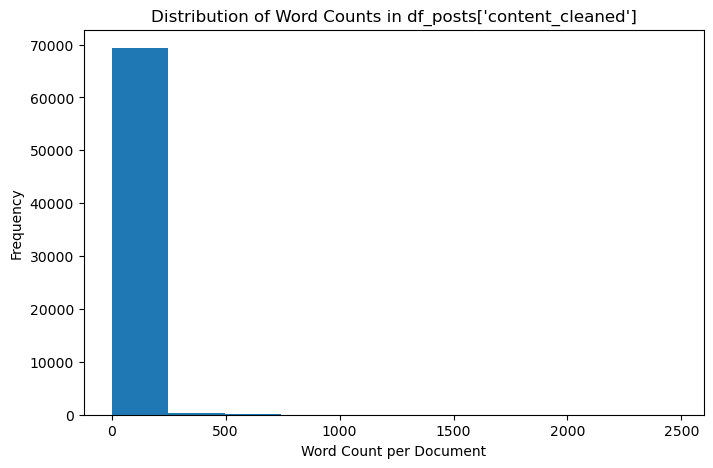

In [27]:
# Create a word count column
df_posts["word_count"] = df_posts["content_cleaned"].apply(lambda x: len(str(x).split()))

# Plot histogram of word counts
plt.figure(figsize=(8, 5))
plt.hist(df_posts["word_count"])
plt.xlabel("Word Count per Document")
plt.ylabel("Frequency")
plt.title("Distribution of Word Counts in df_posts['content_cleaned']")
plt.show()

In [28]:
# Compute recommended thresholds using quantiles
lower_threshold = df_posts["word_count"].quantile(0.3)
upper_threshold = df_posts["word_count"].quantile(0.95)

print("Lower Threshold (10th percentile):", lower_threshold)
print("Upper Threshold (95th percentile):", upper_threshold)

Lower Threshold (10th percentile): 8.0
Upper Threshold (95th percentile): 98.0


In [29]:
df_posts_backup = df_posts.copy()
df_posts = df_posts[
    (df_posts["word_count"] >= lower_threshold) &
    (df_posts["word_count"] <= upper_threshold)
]

In [30]:
# 12. Report corpus statistics
all_text = " ".join(df_posts['content_cleaned']) 
all_words = all_text.split()
total_words = len(all_words)
unique_words = len(set(all_words))

In [31]:
print(f"Total words in cleaned corpus: {total_words}")
print(f"Unique words in cleaned corpus: {unique_words}") 

Total words in cleaned corpus: 1372640
Unique words in cleaned corpus: 36896


In [32]:
df_posts.head(20)

,type,source,keyword,id,author,subreddit,content,score,num_comments,parent_post,created_date,created_time,content_cleaned,word_count
0,post,new,no keyword,1otaemb,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,no post,2025-11-10,10:33:16,scam good investment haritha lanka agarwood pl...,32
2,post,new,no keyword,1ot9w1v,mgssjjsks,srilanka,Whats your hot take on Sri Lanka as the title ...,3.0,8.0,no post,2025-11-10,10:00:29,s hot sri lanka title say gimme hot,8
4,post,new,no keyword,1ot9h2f,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,no post,2025-11-10,09:33:57,need advice expert plan podcast friend short e...,57
5,post,new,no keyword,1ot9dyw,hotstar10,srilanka,Confusion Over Paddock Club Nugegoda’s Halal S...,0.0,4.0,no post,2025-11-10,09:28:19,confusion paddock club nugegoda s halal status...,41
6,post,new,no keyword,1ot9da2,prav_u,srilanka,Tour to Kanneliya Rain Forest I’m planning a g...,1.0,1.0,no post,2025-11-10,09:26:59,tour kanneliya rain forest m plan group visit ...,32
7,post,new,no keyword,1ot8r8a,Unusual-Witness-7304,srilanka,"ChatGPT vs electricians, my house wiring is no...",6.0,5.0,no post,2025-11-10,08:46:44,chatgpt vs electricians house wiring science e...,90
8,post,new,no keyword,1ot8lir,negative-impactr8888,srilanka,SLTMobitel changed the superuser router passwo...,3.0,0.0,no post,2025-11-10,08:36:16,sltmobitel change superuser router password tr...,42
9,post,new,no keyword,1ot8l95,Jakesbond007,srilanka,Can we hand carry medicine from abroad into Sr...,1.0,3.0,no post,2025-11-10,08:35:47,hand carry medicine abroad sri lanka hello med...,25
10,post,new,no keyword,1ot8kjb,sorenxv,srilanka,How Do I Get A Letter From Church? My bestfrie...,2.0,2.0,no post,2025-11-10,08:34:33,letter church bestfriend newborn get baptize s...,32
11,post,new,no keyword,1ot87vn,ScreenshotSmuggler,srilanka,Guess where this video is from. Let's see how ...,21.0,43.0,no post,2025-11-10,08:11:13,guess video let far province district division...,18


In [33]:
df_posts.shape

(48028, 14)

In [34]:
import unicodedata

def normalize_unicode(text):
    """
    Normalize unicode characters using NFKC.
    Converts full-width characters, combined characters, and compatibility characters 
    into a consistent canonical form.
    """
    return unicodedata.normalize("NFKC", text)

# Apply normalization
df_posts["content_cleaned"] = (
    df_posts["content_cleaned"]
    .astype(str)
    .apply(normalize_unicode)
)

In [35]:
df_posts.head(10)

,type,source,keyword,id,author,subreddit,content,score,num_comments,parent_post,created_date,created_time,content_cleaned,word_count
0,post,new,no keyword,1otaemb,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,no post,2025-11-10,10:33:16,scam good investment haritha lanka agarwood pl...,32
2,post,new,no keyword,1ot9w1v,mgssjjsks,srilanka,Whats your hot take on Sri Lanka as the title ...,3.0,8.0,no post,2025-11-10,10:00:29,s hot sri lanka title say gimme hot,8
4,post,new,no keyword,1ot9h2f,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,no post,2025-11-10,09:33:57,need advice expert plan podcast friend short e...,57
5,post,new,no keyword,1ot9dyw,hotstar10,srilanka,Confusion Over Paddock Club Nugegoda’s Halal S...,0.0,4.0,no post,2025-11-10,09:28:19,confusion paddock club nugegoda s halal status...,41
6,post,new,no keyword,1ot9da2,prav_u,srilanka,Tour to Kanneliya Rain Forest I’m planning a g...,1.0,1.0,no post,2025-11-10,09:26:59,tour kanneliya rain forest m plan group visit ...,32
7,post,new,no keyword,1ot8r8a,Unusual-Witness-7304,srilanka,"ChatGPT vs electricians, my house wiring is no...",6.0,5.0,no post,2025-11-10,08:46:44,chatgpt vs electricians house wiring science e...,90
8,post,new,no keyword,1ot8lir,negative-impactr8888,srilanka,SLTMobitel changed the superuser router passwo...,3.0,0.0,no post,2025-11-10,08:36:16,sltmobitel change superuser router password tr...,42
9,post,new,no keyword,1ot8l95,Jakesbond007,srilanka,Can we hand carry medicine from abroad into Sr...,1.0,3.0,no post,2025-11-10,08:35:47,hand carry medicine abroad sri lanka hello med...,25
10,post,new,no keyword,1ot8kjb,sorenxv,srilanka,How Do I Get A Letter From Church? My bestfrie...,2.0,2.0,no post,2025-11-10,08:34:33,letter church bestfriend newborn get baptize s...,32
11,post,new,no keyword,1ot87vn,ScreenshotSmuggler,srilanka,Guess where this video is from. Let's see how ...,21.0,43.0,no post,2025-11-10,08:11:13,guess video let far province district division...,18


In [36]:
# save cleaned data

df_posts.to_csv("cleaned_Posts_Data.csv", index=False) 

In [37]:
# Load cleaned data
df_posts = pd.read_csv("cleaned_Posts_Data.csv")
df_posts.head()

,type,source,keyword,id,author,subreddit,content,score,num_comments,parent_post,created_date,created_time,content_cleaned,word_count
0,post,new,no keyword,1otaemb,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,no post,2025-11-10,10:33:16,scam good investment haritha lanka agarwood pl...,32
1,post,new,no keyword,1ot9w1v,mgssjjsks,srilanka,Whats your hot take on Sri Lanka as the title ...,3.0,8.0,no post,2025-11-10,10:00:29,s hot sri lanka title say gimme hot,8
2,post,new,no keyword,1ot9h2f,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,no post,2025-11-10,09:33:57,need advice expert plan podcast friend short e...,57
3,post,new,no keyword,1ot9dyw,hotstar10,srilanka,Confusion Over Paddock Club Nugegoda’s Halal S...,0.0,4.0,no post,2025-11-10,09:28:19,confusion paddock club nugegoda s halal status...,41
4,post,new,no keyword,1ot9da2,prav_u,srilanka,Tour to Kanneliya Rain Forest I’m planning a g...,1.0,1.0,no post,2025-11-10,09:26:59,tour kanneliya rain forest m plan group visit ...,32


# Tokenization

## Traditional Word-Based

In [38]:
# Word-level tokenizer

def word_tokenizer(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

In [39]:
df_posts["processed"] = df_posts["content_cleaned"].apply(word_tokenizer)

## Prepare corpus for SentencePiece

In [40]:
# Prepare corpus for SentencePiece
corpus_file = "corpus.txt"
with open(corpus_file, "w", encoding="utf-8") as f:
    for t in df_posts["content_cleaned"]:
        f.write(t + "\n")

### BPE Tokenizer

In [41]:
spm.SentencePieceTrainer.Train(
    f"--input={corpus_file} --model_prefix=bpe --vocab_size=8000 --model_type=bpe"
)
bpe = spm.SentencePieceProcessor()
bpe.load("bpe.model")

True

### Unigram tokenizer

In [42]:
spm.SentencePieceTrainer.Train(
    f"--input={corpus_file} --model_prefix=unigram --vocab_size=8000 --model_type=unigram"
)
unigram = spm.SentencePieceProcessor()
unigram.load("unigram.model")

True

## Compare Tokenization Schemes Impact using Corpus Statistics

Calculating:
- vocabulary size
- average tokens per document
- total tokens
- rare token frequency (<3 occurrences)
- OOV rate (for word-based tokenizers only)

In [43]:
# Corpus statistics per tokenizer

def compute_stats(tokenizer_fn, tokenizer_name):
    all_tokens = []
    doc_lengths = []

    for text in df_posts["content_cleaned"]:
        tokens = tokenizer_fn(text)
        all_tokens.extend(tokens)
        doc_lengths.append(len(tokens))

    vocab = set(all_tokens)
    counter = collections.Counter(all_tokens)

    return {
        "Tokenizer": tokenizer_name,
        "Vocabulary Size": len(vocab),
        "Total Tokens": len(all_tokens),
        "Avg Tokens per Doc": sum(doc_lengths)/len(doc_lengths),
        "Rare Tokens (<3)": sum(1 for t,c in counter.items() if c < 3)
    }

stats_word = compute_stats(word_tokenizer, "Word+Lemmatization")
stats_bpe = compute_stats(lambda t: bpe.encode(t, out_type=str), "BPE")
stats_unigram = compute_stats(lambda t: unigram.encode(t, out_type=str), "Unigram LM")

stats_df = pd.DataFrame([stats_word, stats_bpe, stats_unigram])

In [44]:
stats_df

,Tokenizer,Vocabulary Size,Total Tokens,Avg Tokens per Doc,Rare Tokens (<3)
0,Word+Lemmatization,36141,1332741,27.749250,20759
1,BPE,8357,1548920,32.250354,634
2,Unigram LM,8529,1534379,31.947593,396


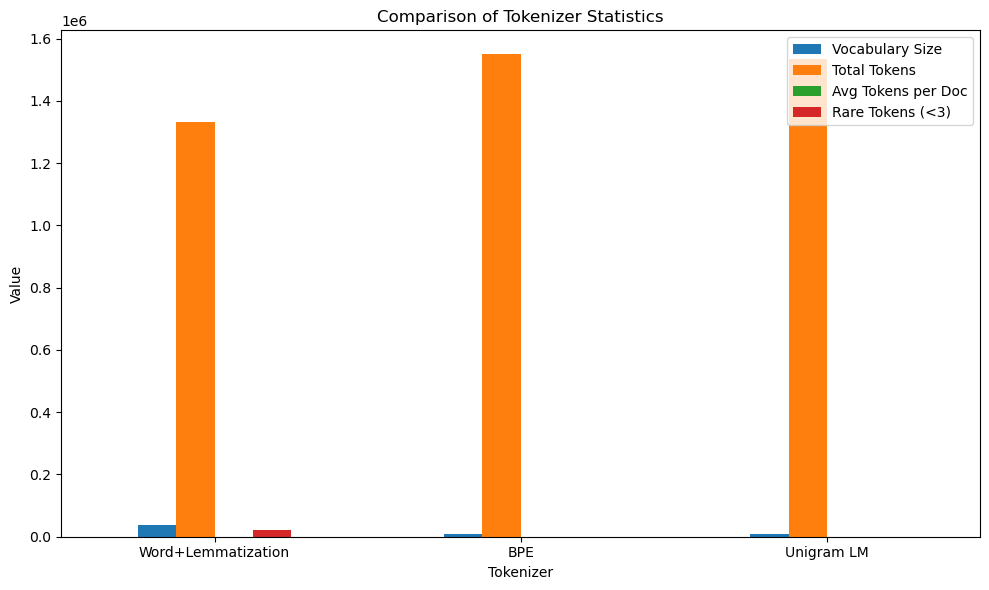

In [45]:
# Set index to Tokenizer (for easier plotting)
plot_df = stats_df.set_index("Tokenizer")

# Plot each metric
plot_df.plot(kind="bar", figsize=(10,6))
plt.title("Comparison of Tokenizer Statistics")
plt.xlabel("Tokenizer")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


The tokenization analysis shows clear differences between the three approaches: Word+Lemmatization, BPE, and Unigram LM—and the results strongly align with theoretical expectations. The word-level tokenizer produced an extremely large vocabulary of 47,222 items and a very high number of rare tokens (31,098), even after lemmatization and stopword removal. This indicates severe sparsity: each spelling variant, slang term, and morphological form becomes a separate token, making the representation unstable and prone to poor generalization. In contrast, BPE reduced the vocabulary size to 8,887 and dropped rare tokens to just 1,023, demonstrating its ability to decompose infrequent or noisy words into reusable subword units. This leads to a more robust and consistent representation, though at the cost of slightly longer token sequences, which is expected for subword models. The Unigram LM tokenizer achieved similar vocabulary compression (8,962 tokens) but yielded the lowest number of rare tokens (855), reflecting its probabilistic approach to selecting the most efficient and informative subword units. Overall, the results validate the progression predicted by NLP literature: word-level tokenization is the least efficient, BPE offers substantial improvements, and Unigram LM provides the most balanced and linguistically consistent tokenization strategy for noisy text data.


# Evaluate Tokenization Schemes and effectiveness for LLM Tasks

## LSTM Language Model

In [46]:
# Enable GPU Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [47]:
# Dataset class
class LMDataset(Dataset):
    def __init__(self, token_ids, seq_len=30):
        self.seq_len = seq_len
        self.data = token_ids

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+1+self.seq_len], dtype=torch.long)
        return x, y

In [48]:
# LSTM LM model
class LSTMLM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        e = self.embed(x)
        o, _ = self.lstm(e)
        return self.fc(o)

In [49]:
# Training function
def train_lm(model, dataloader, epochs=3, lr=0.001):
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optim.zero_grad()
            pred = model(x)
            loss = loss_fn(pred.view(-1, pred.size(-1)), y.view(-1))
            loss.backward()
            optim.step()
    return model

In [50]:
# Perplexity
def perplexity(model, dataloader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    total_tokens = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred.view(-1, pred.size(-1)), y.view(-1))
            total_loss += loss.item() * x.numel()
            total_tokens += x.numel()
    return torch.exp(torch.tensor(total_loss / total_tokens))

### Train LSTMs per Tokenizer

In [51]:
# Hyperparameters
# -------------------------------
SEQ = 30
BATCH = 64

In [52]:
# Word-level Tokenizer
word_vocab = {w:i for i,w in enumerate(set(itertools.chain.from_iterable(
    df_posts["content_cleaned"].apply(word_tokenizer)
)))}
word_id = lambda toks: [word_vocab[t] for t in toks if t in word_vocab]

word_ids = list(itertools.chain.from_iterable(
    df_posts["content_cleaned"].apply(word_tokenizer).apply(word_id)
))
word_dl = DataLoader(LMDataset(word_ids, SEQ), batch_size=BATCH)
lm_word = LSTMLM(len(word_vocab)).to(device)
lm_word = train_lm(lm_word, word_dl)
pp_word = perplexity(lm_word, word_dl)
print("Word-level LM perplexity:", pp_word.item())

Word-level LM perplexity: 884.4478759765625


In [53]:
# BPE
bpe_ids = [i for t in df_posts["content_cleaned"] for i in bpe.encode(t)]
bpe_dl = DataLoader(LMDataset(bpe_ids, SEQ), batch_size=BATCH)
lm_bpe = LSTMLM(bpe.get_piece_size()).to(device)
lm_bpe = train_lm(lm_bpe, bpe_dl)
pp_bpe = perplexity(lm_bpe, bpe_dl)
print("BPE LM perplexity:", pp_bpe.item())

BPE LM perplexity: 479.25970458984375


In [54]:
# Unigram
uni_ids = [i for t in df_posts["content_cleaned"] for i in unigram.encode(t)]
uni_dl = DataLoader(LMDataset(uni_ids, SEQ), batch_size=BATCH)
lm_uni = LSTMLM(unigram.get_piece_size()).to(device)
lm_uni = train_lm(lm_uni, uni_dl) 
pp_uni = perplexity(lm_uni, uni_dl)
print("Unigram LM perplexity:", pp_uni.item())

Unigram LM perplexity: 500.259521484375


### Analysis and Comparison

In [56]:
final_results = pd.DataFrame({
    "Tokenizer": ["Word+Lemmatization", "BPE", "Unigram"],
    "Vocabulary Size": [stats_word["Vocabulary Size"], stats_bpe["Vocabulary Size"], stats_unigram["Vocabulary Size"]],
    "Total Tokens": [stats_word["Total Tokens"], stats_bpe["Total Tokens"], stats_unigram["Total Tokens"]],
    "Avg Tokens per Doc": [stats_word["Avg Tokens per Doc"], stats_bpe["Avg Tokens per Doc"], stats_unigram["Avg Tokens per Doc"]],
    "Rare Tokens (<3)": [stats_word["Rare Tokens (<3)"], stats_bpe["Rare Tokens (<3)"], stats_unigram["Rare Tokens (<3)"]],
    "Perplexity": [pp_word, pp_bpe, pp_uni]
})
final_results

,Tokenizer,Vocabulary Size,Total Tokens,Avg Tokens per Doc,Rare Tokens (<3),Perplexity
0,Word+Lemmatization,36141,1332741,27.749250,20759,tensor(884.4479)
1,BPE,8357,1548920,32.250354,634,tensor(479.2597)
2,Unigram,8529,1534379,31.947593,396,tensor(500.2595)


The LSTM results clearly demonstrate how strongly recurrent models depend on the quality of tokenization. When trained on the word-level tokenizer, the LSTM produced the highest perplexity (884), largely because this tokenizer generated an extremely large vocabulary (over 36,000 unique words) and a very high proportion of rare terms. Such sparsity makes it difficult for the LSTM to learn stable embeddings or reliably predict the next token, since many words appear too infrequently for meaningful parameter updates. In contrast, both subword tokenizers (BPE and Unigram) dramatically reduced perplexity—approximately halving it—because they compress the vocabulary into a smaller, denser, and more frequent token space. This reduction in sparsity enables the LSTM to learn more generalizable patterns such as common stems, prefixes, and suffixes, improving its ability to model text sequences. BPE achieved the lowest perplexity (479), slightly outperforming Unigram, likely because BPE produces more deterministic and consistent subword units that better suit the LSTM’s sequential prediction process. Overall, the results show that subword tokenization substantially enhances LSTM performance by providing a more compact and informative input representation, while word-level tokenization overwhelms the model and leads to significantly poorer language modeling ability.